# Sanity checks: PREK SSVEP data

In [1]:
import os
import numpy as np
from scipy.fft import rfft, rfftfreq
from mayavi import mlab
mlab.init_notebook('png')

import mne
mne.cuda.init_cuda()

Notebook initialized with png backend.
Now using CUDA device 0
Enabling CUDA with 4.69 GB available memory


In [2]:
def div_by_adj_bins(data, n_bins=2, method='mean', return_noise=False):
    """Divides FFT bins by their adjacent bins, to estimate SNR.
    
    data : np.ndarray
        the data to enhance
    n_bins : int
        number of bins on either side to include.
    method : 'mean' | 'sum'
        whether to divide by the sum or average of adjacent bins.
    """
    from scipy.ndimage import convolve1d
    weights = np.ones(2 * n_bins + 1)
    weights[n_bins] = 0  # don't divide target bin by itself
    if method == 'mean':
        weights /= 2 * n_bins
    noise = convolve1d(data, mode='constant', weights=weights)
    return noise if return_noise else data / noise

### setup/config

In [3]:
subj = 'prek_1103'
timepoint = 'pre'
#root = '/mnt/scratch/prek'  # colchuck
root = '/data/prek'          # agelaius

subjects_dir = os.path.join(root, 'anat')

# if you want to save intermediate files:
epo_dir = os.path.join(root, 'results', 'epochs')
evk_dir = os.path.join(root, 'results', 'evoked')
fft_dir = os.path.join(root, 'results', 'fft')
stc_dir = os.path.join(root, 'results', 'stc')
psd_dir = os.path.join(root, 'results', 'fig', 'psd')
brain_dir = os.path.join(root, 'results', 'fig', 'brain')
for _dir in (epo_dir, evk_dir, stc_dir, fft_dir, psd_dir, brain_dir):
    os.makedirs(_dir, exist_ok=True)

In [4]:
# config
runs = (1, 2)
trial_dur = 20        # seconds
subdivide_epochs = 5  # seconds

# filename config
subdiv = f'-{subdivide_epochs}_sec' if subdivide_epochs else ''
filename_stub = f'{subj}-{timepoint}_camp-pskt{subdiv}'

## Epoching

### Load raw files for one subject

In [5]:
this_subj = os.path.join(root, f'{timepoint}_camp', 'twa_hp', 'pskt', subj)
raws = list()
events_list = list()
# extract the events from the original raw (STIM channels are dropped from the preprocessed raw)
for run in runs:
    this_fname = f'{subj}_pskt_{run:02}_{timepoint}_raw.fif'
    raw_path = os.path.join(this_subj, 'raw_fif', this_fname)
    raw = mne.io.read_raw_fif(raw_path, allow_maxshield=True, verbose=False)
    eve = mne.find_events(raw, stim_channel='STI001')
    eve[3:, 2] = 7  # change event numbers to represent PS and KT trials differently
    events_list.append(eve)
# now process the clean files
for run in runs:
    this_fname = f'{subj}_pskt_{run:02}_{timepoint}_allclean_fil80_raw_sss.fif'
    raw_path = os.path.join(this_subj, 'sss_pca_fif', this_fname)
    raw = mne.io.read_raw_fif(raw_path, verbose=False)
    raws.append(raw)
# combine runs
raw, events = mne.concatenate_raws(raws, events_list=events_list)

6 events found
Event IDs: [5]
6 events found
Event IDs: [5]


<ipython-input-5-a002caa04620>:8: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne.io.read_raw_fif(raw_path, allow_maxshield=True, verbose=False)
<ipython-input-5-a002caa04620>:8: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne.io.read_raw_fif(raw_path, allow_maxshield=True, verbose=False)


### if requested, make multiple epochs from each 20-second trial

In [6]:
# subdivide
if subdivide_epochs:
    assert trial_dur % subdivide_epochs == 0
    n_new_events = trial_dur // subdivide_epochs
    t_offsets = np.arange(n_new_events, dtype=float) * subdivide_epochs
    samp_offsets = np.round(t_offsets * raw.info['sfreq']).astype(int)
    new_indices = (events[:, [0]] + samp_offsets[np.newaxis]).ravel()
    events = np.column_stack((new_indices,
                              np.zeros_like(new_indices),
                              np.repeat(events[:, -1], n_new_events)))

### Downsample and delete original raws

In [7]:
# downsample
raw, events = raw.resample(sfreq=50, events=events, n_jobs='cuda')
# clean up
del raws, events_list

### Epoch

In [8]:
# epoch
event_dict = dict(ps=5, kt=7)
tmax = subdivide_epochs if subdivide_epochs else trial_dur
epochs = mne.Epochs(raw, events, event_dict, tmin=0, tmax=tmax,
                    baseline=None, proj=True,
                    reject_by_annotation=False, preload=True)
# trim last sample from epochs so our FFT bins come out nicely spaced
epochs.crop(tmax=tmax, include_tmax=False)
assert len(epochs.times) % 10 == 0

Not setting metadata
Not setting metadata
48 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 48 events and 251 original time points ...
0 bad epochs dropped


### Save epochs

In [9]:
fname = f'{filename_stub}-epo.fif'
epochs.save(os.path.join(epo_dir, fname), fmt='double', overwrite=True)

Overwriting existing file.


## Plot sensor PSD

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


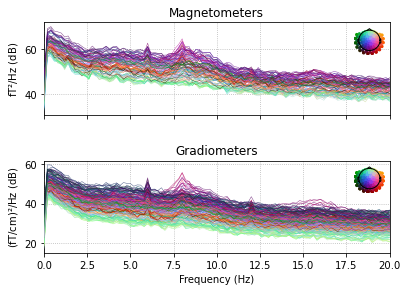

In [10]:
fig = epochs.plot_psd(fmin=0, fmax=20, bandwidth=0.2, low_bias=False)

In [11]:
fname = f'{filename_stub}-sensor_psd.pdf'
fig.savefig(os.path.join(psd_dir, fname))

## FFT and inverse

### Setup

In [12]:
snr = 3.
lambda2 = 1. / snr ** 2
smoothing_steps = 10

In [13]:
# create & save evoked
evoked = epochs.average()
fname = f'{filename_stub}-ave.fif'
evoked.save(os.path.join(evk_dir, fname))
del epochs

In [14]:
# FFT setup
spacing = 1. / evoked.info['sfreq']
freqs = rfftfreq(evoked.times.size, spacing)

In [15]:
# inverse is only located in the ERP folder tree, not in PSKT
inv_path = os.path.join(root, f'{timepoint}_camp', 'twa_hp', 'erp', subj, 'inverse', f'{subj}-80-sss-meg-inv.fif')
inverse = mne.minimum_norm.read_inverse_operator(inv_path)

Reading inverse operator decomposition from /data/prek/pre_camp/twa_hp/erp/prek_1103/inverse/prek_1103-80-sss-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    306 x 306 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        planar-ECG--0.08-0.08-PCA-01 (1 x 204)  idle
        axial-ECG--0.08-0.08-PCA-01 (1 x 102)  idle
        planar-EOG--0.25-0.25-PCA-01 (1 x 204)  idle
        axial-EOG--0.25-0.25-PCA-01 (1 x 102)  idle
    Noise covariance matrix read.
    24588 x 24588 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    24588 x 24588 diagonal covariance (kind = 6) found.
    Orientation priors read.
    24588 x 24588 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added

### brain plot setup

In [16]:
brain_plot_kwargs = dict(
    views=['lat', 'med', 'ven'],
    hemi='split',
    size=[800, 800],
    subjects_dir=subjects_dir)

### morph setup (optional)

In [17]:
#fsaverage_src_path = os.path.join(subjects_dir, 'fsaverage', 'bem', 'fsaverage-ico-5-src.fif')
#fsaverage_src = mne.read_source_spaces(fsaverage_src_path)
#fsaverage_vertices = [s['vertno'] for s in fsaverage_src]
#morph = mne.compute_source_morph(stc, subject_from=subj.upper(), subject_to='fsaverage', subjects_dir=subjects_dir, spacing=fsaverage_vertices, smooth=smoothing_steps)

### Inverse first, then FFT

In [18]:
# go to source space
stc = mne.minimum_norm.apply_inverse(evoked, inverse, lambda2, pick_ori='normal')

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 48
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 4)
    Created the whitener using a noise covariance matrix with rank 78 (228 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.50 * ps + 0.50 * kt"...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  80.4% variance
    dSPM...
[done]


In [19]:
# FFT
stc.data = rfft(stc.data, workers=-2)
stc.tstep = np.diff(freqs[:2])
fname = f'{filename_stub}-inverse_before_fft'
stc.save(os.path.join(stc_dir, fname), ftype='h5')

[done]


Using mayavi 3d backend.

Using control points [ 68.65956008  86.03325792 250.34403562]



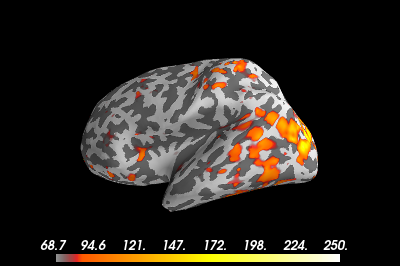


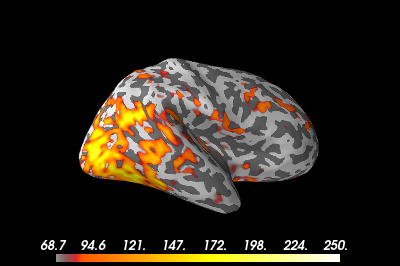


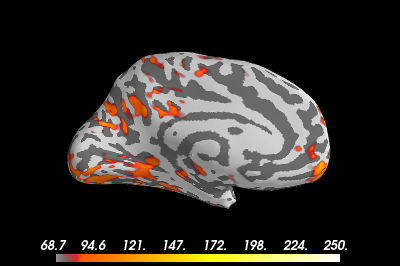


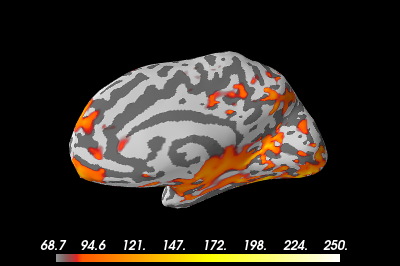


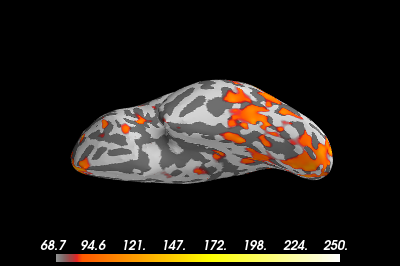


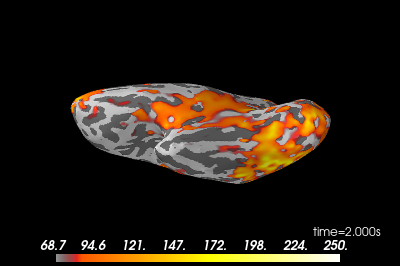

In [20]:
# replace complex-valued STC data with magnitude, then plot
stc.data = np.abs(stc.data)
brain = stc.plot(subject=subj.upper(), initial_time=2, **brain_plot_kwargs)
brain

Using control points [ 2.71604775  3.11838772 12.14037224]



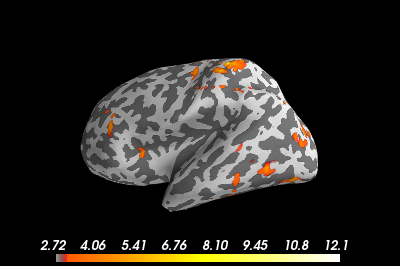


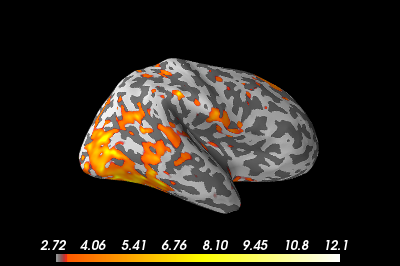


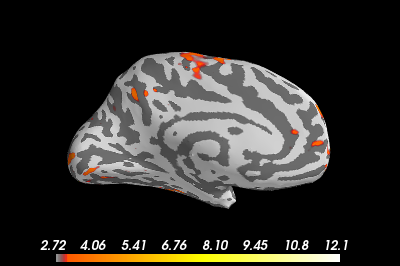


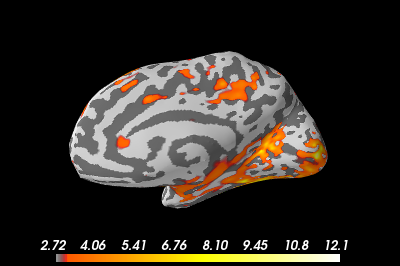


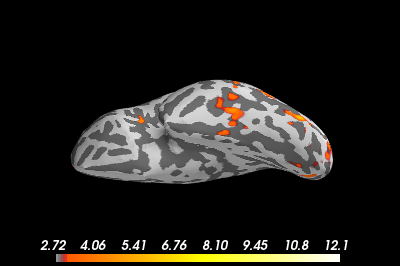


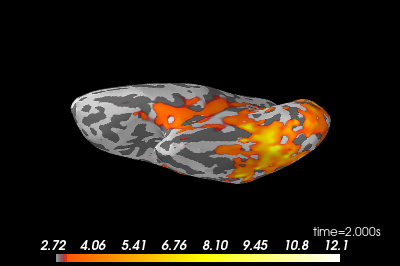

In [21]:
# now convert to SNR estimates
stc.data = div_by_adj_bins(stc.data)
brain = stc.plot(subject=subj.upper(), initial_time=2, **brain_plot_kwargs)
brain

### FFT first, then inverse

In [22]:
# FFT
spectrum = rfft(evoked.data, workers=-2)
fname = f'{filename_stub}-sensor_fft.npz'
np.savez(os.path.join(fft_dir, fname), spectrum=spectrum, freqs=freqs)

In [23]:
# convert to fake evoked object
evoked_spect = mne.EvokedArray(spectrum, evoked.info, nave=evoked.nave)
evoked_spect.times = freqs
evoked_spect.info['sfreq'] = 1. / np.diff(freqs[:2])[0]

In [24]:
# go to source space
stc = mne.minimum_norm.apply_inverse(evoked_spect, inverse, lambda2, pick_ori='normal')
assert stc.tstep == np.diff(freqs[:2])
assert np.all(stc.times == freqs)
fname = f'{filename_stub}-fft_before_inverse'
stc.save(os.path.join(stc_dir, fname), ftype='h5')

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 48
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 4)
    Created the whitener using a noise covariance matrix with rank 78 (228 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to ""...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  80.4% variance
    dSPM...
[done]
[done]


Using control points [ 68.65956008  86.03325792 250.34403562]



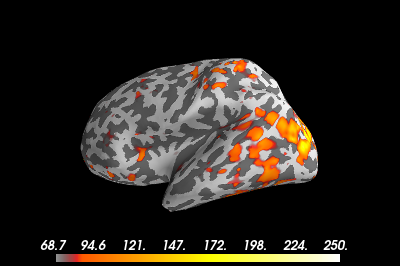


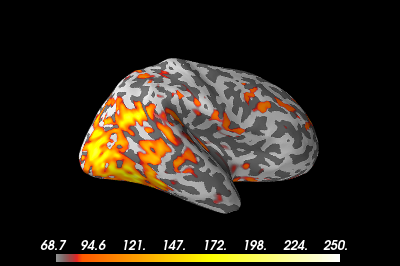


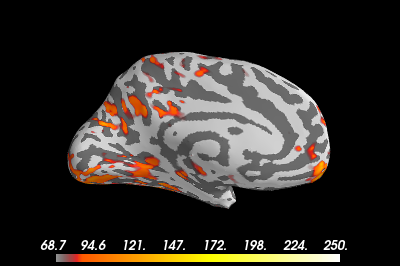


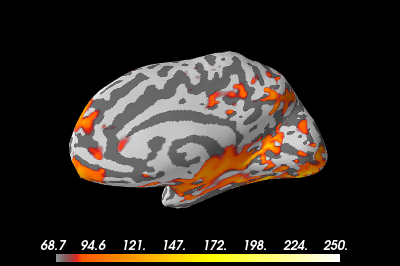


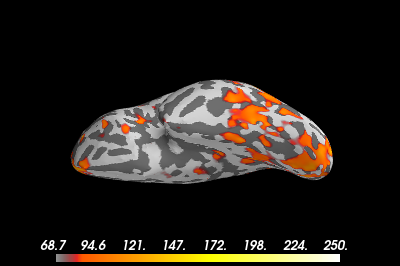


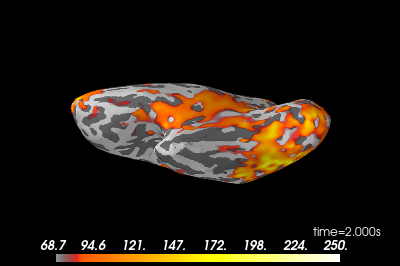

In [25]:
# replace complex-valued STC data with magnitude, then plot
stc.data = np.abs(stc.data)
brain = stc.plot(subject=subj.upper(), initial_time=2, **brain_plot_kwargs)
brain

Using control points [ 2.71604775  3.11838772 12.14037224]



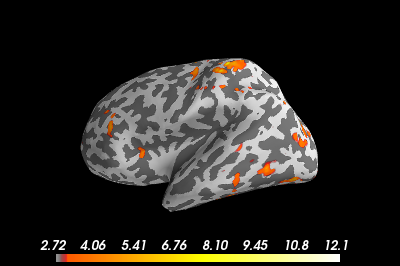


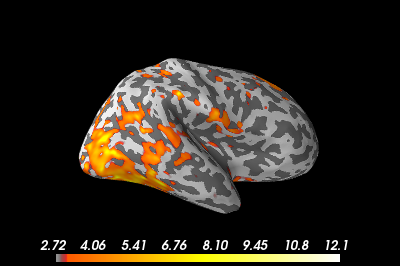


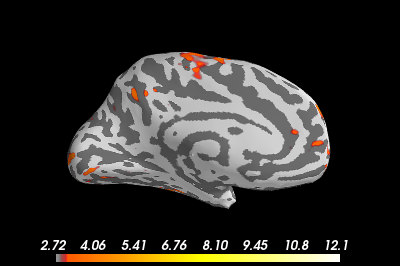


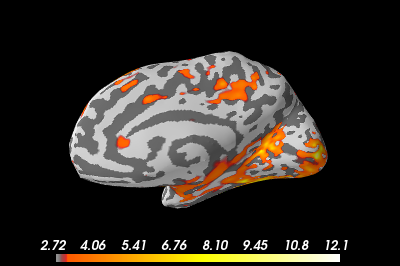


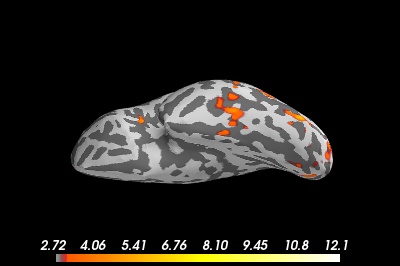


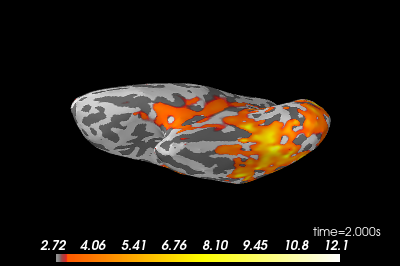

In [26]:
# now convert to SNR estimates
stc.data = div_by_adj_bins(stc.data)
brain = stc.plot(subject=subj.upper(), initial_time=2, **brain_plot_kwargs)
brain

### test equivalence

In [27]:
fname = f'{filename_stub}-inverse_before_fft'
stc1 = mne.read_source_estimate(os.path.join(stc_dir, fname))

fname = f'{filename_stub}-fft_before_inverse'
stc2 = mne.read_source_estimate(os.path.join(stc_dir, fname))

assert np.allclose(stc1.data, stc2.data)